# PyTorch Paper Replicating

This file will focus on replicating a Machine Learning research paper and creating a Vision Transformer (ViT) from scratch.

### What is paper replicating?

The goal of paper replicating is to replicate the most recent advances in Machine Learning which tend to be published in papers. Instead of using someone else's code, the focus here is to transform images, diagrams, math and text into usable code, in this case, PyTorch code.

### Where can code examples of Machine Learning research papers be found?

There is a lot of research in Machine Learning, so staying on top of the most recent advances is not easy. Said this, there are several places to find relevant papers.

Some useful resources include:
* arXiv
* AK Twitter
* Papers with Code
* lucidrains' `vit-pytorch` GitHub repository

### Which paper will be replicated?

The paper this file will focus on An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (ViT paper)
https://arxiv.org/abs/2010.11929

The Transformer neural network architecture was originally introduced in the Machine Learning research paper Attention is all you need
https://arxiv.org/abs/1706.03762

A Transformer architecture is generally considered to be any neural network that uses the attention mechanism as its primary learning layer. This is similar to how Convolutional Neural Networks use convolutions as their primary learning layer.

The Attention Mechanism is more thoroughly explained here:
https://www.geeksforgeeks.org/ml-attention-mechanism/

As suggested by its name, the Vision Transformer (ViT) architecture was designed to adapt the original Transformer architecture to vision problems.

The original Vision Transformer has been through several iterations over the past couple of years, but we will focus on replicating the original.

For the rest of this project, we will refer to the Vision Transformer as ViT while referring to the original Machine Learning research paper as ViT paper.

## 0. Setup

In [46]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.+"
    assert int(torchvision.__version__.split(".")[1]) >= 15, "torchvision version should be 0.15+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not correct. Installing correct versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [47]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Could not find going_modular scripts. Downloading them from GitHub.")
    !git clone https://github.com/Aaron-Serpilin/Zero-To-Mastery-Pytorch
    !mv Zero-To-Mastery-Pytorch/Fundamentals/going_modular .
    !mv Zero-To-Mastery-Pytorch/Fundamentals/helper_functions.py .
    !rm -rf Zero-To-Mastery-Pytorch
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

In [49]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [50]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images

In [51]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into `DataLoader`'s

The ViT paper states the use of a batch size of 4096, which is considerably bigger than the batch size of 32 we have been using so far. However, we will stick with 32 because due to hardware limitations, handling batches of 4096 would be challenging.

In [52]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f04d5100410>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [53]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

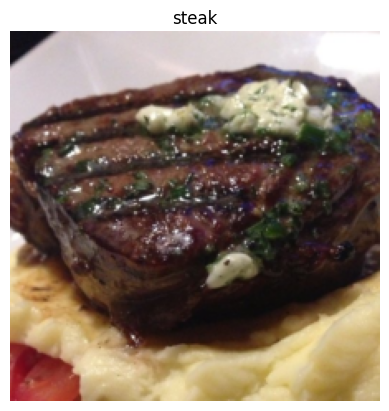

In [54]:
plt.imshow(image.permute(1, 2, 0)) # rearrange to suit matplotlib (go from [CHW] to [HWC])
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating the ViT paper: an overview

### 3.1 Inputs and Outputs, Layer and Blocks

Neural networks are composed of layers, which can be grouped together into blocks. Said blocks can then be stacked together to provide a more thorough architecture.

Here is a breakdown of these:

* Layer: takes an input, performs a function on it, returns an output.
* Block: a collection of layers, takes an input, performs a series of functions on it, returns an output.
* Architecture (or model): a collection of blocks, takes an input, performs a series of functions on it, returns an output.

When replicating a paper, one must do it layer by layer, block by block, function by function.

### 3.2 What is ViT made of?

The ViT model paper has many details, but our focus of analysis are three resources:

1. Figure 1: gives an overview of the model in a graphical sense. You could almost recreate the architecture with this figure alone.
2. Four equations in section 3.1: These equations give a little bit more of a mathematical grounding to the colored blocks in Figure 1.
3. Table 1: This table shows the various hyperparameter settings for different ViT model variants.

#### 3.1.2 Figure 1

The main analysis of this section is around two features:

1. Layers
2. Blocks

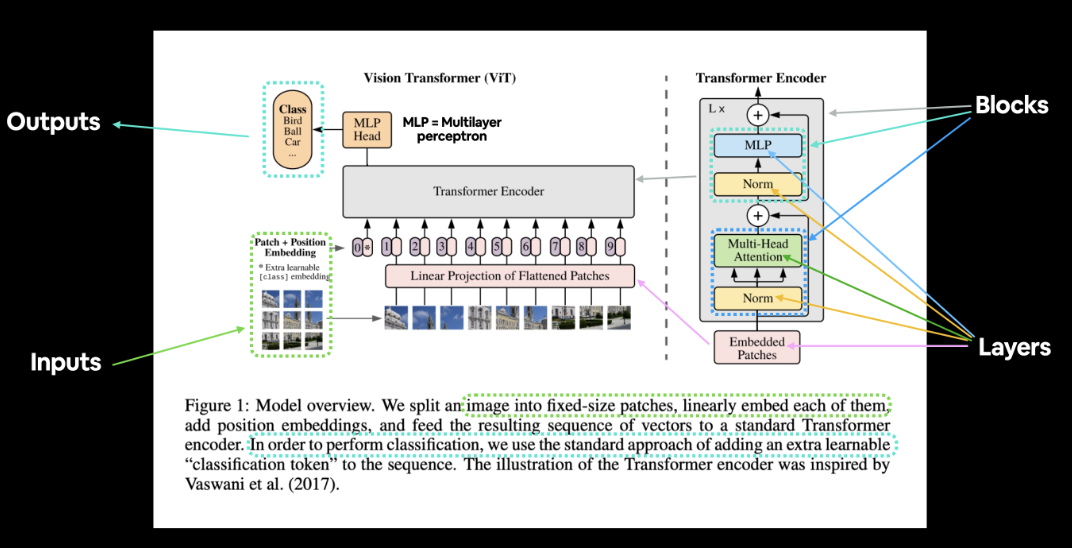

The ViT Architecture is comprised of several stages:

* **Patch + Position Embedding (inputs)**: Converts the input image into a sequence of image patches. A position number is then added given that transformers are almost a type of content based set operation. Hence, in order for it to retain positional information, it is assigned a position number and is passed to the self attention.
* **Linear Projection of Flattened Patches (Embedded Patches)**: The image patches get turned into an embedding which are essentially learnable representations. This extracts more data and meanings from the image patches, and can improve with training.
* **Norm**: Short for Layer Normalization or LayerNorm. It is a technique for regularizing (reducing overfitting) in a neural network. It can be used through `torch.nn.LayerNorm()`
* **Multi-Head Attention**: The model employs a MSA layer which allows it to focus on multiple parts of the input sequences simultaneously. This can be used through `torch.nn.MultiheadAttention()`
* **Multilayer Perceptron (MLP)**: A MLP can often refer to any collection of feedforward layers, which in PyTorch are a collection of layers with a `forward()` method. In the ViT paper, the authors refer to this as a 'MLP Block', which contains two `torch.nn.Linear()` layers with a `torch.nn.GELU()` non-linearity activation in between. This is detailed in section 3.1, which is complemented by a `torch.nn.Dropout()` layer after each, detailed in Appendix B.1.
* **Transformer Encoder**: The Transformer Encoder is a collection of the layers listed above. These are complemented by two skip (or residual) connections inside the Transformer's encoder (the "+" symbols). This means that the inputs are fed directly to immediate layers as well as subsequent layers. This is benefitial because it allows that at the start of the training, when the gradient signal is still being initialized, the second signal goes through without any delay due to initialization. Hence, the lower layers can start training on this signal, and then incorporate the gradient once it is propagated through the block. Overall, it facilitates gradient flow, helps the model learn modifications rather than complete transformations, and stabilizes training.
* **MLP Head**: This is the output layer, it converts the learned features of an input to a class output. This could be seen as the classifier head.

Given the detail of the paper, everything could be coded from scratch, which would be a challenging and educative exercise. However, pre-existing PyTorch layers have already been extensively tested and performance checked.

#### 3.2.2 The Four Equations

The main equations of section 3.1 go over the math behind the ViT architecture.

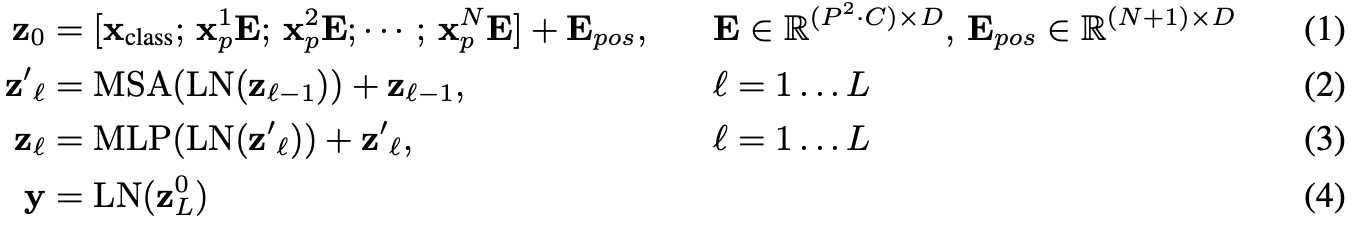

Below is a description of the four equations with the number being the equation number. The descriptions are cited from the paper:
1. The Transformer uses constant latent vector size D through all of its layers, so we
flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.
2. The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).
3. Same as equation 2.
4. Similar to BERT’s [class] token, we prepend a learnable embedding to the sequence of embedded patches ($z_0^0$ = $x_{class}$), whose state at the output of the Transformer encoder ($z_L^0$) serves as the image representation y.


Here is a breakdown of the descriptions with Figure 1

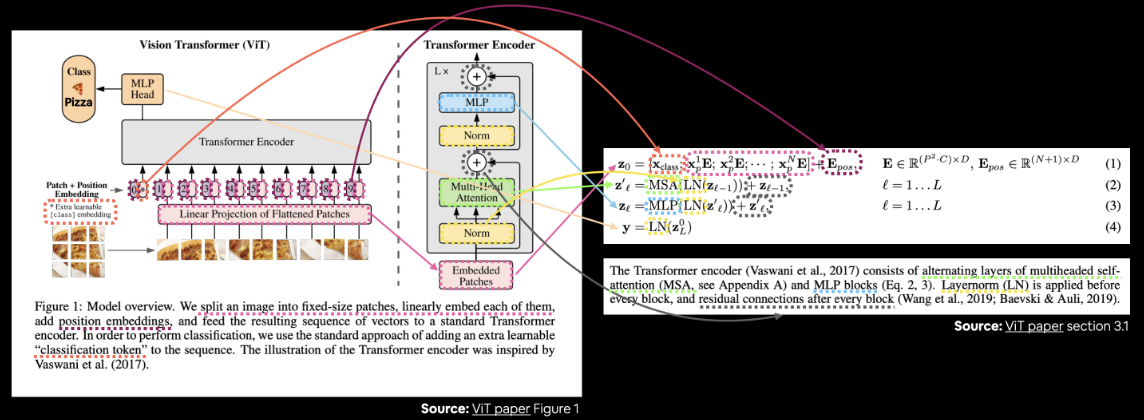

Throughout the equations, "z" is always the output of a particular layer.

1. $z_0$ os the output of the initial embedding layer.
2. $z_l^{'}$ is the output a particular layer prime, or an intermediary value of z.
3. $z_l$ is the output of a particular layer

Additionally, y is the overall output of the architecture.


#### 3.2.3 Equation 1 Overview

$\mathbf{z}_0=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\mathrm{pos}}, \quad \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\mathrm{pos}} \in \mathbb{R}^{(N+1) \times D}$

This equation deals with the class token, patch embedding and position embedding of the input image. The bold capital letter E stands for the embedding.

In vector form, the embedding might look something like:
```
x_input = [class_token, image_patch_1, image_patch_2,
image_patch_3...] + [class_token_position,
image_patch_1_position, image_patch_2_position,
image_patch_3_position...]
```

Here, each element in the vector is learnable (`requires_grad=True`)



#### 3.2.4 Equation 2 Overview

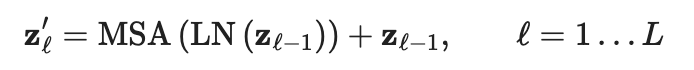

This equation states that every layer from 1 through L which is the total number of layers, there is a MSA wrapping a LN.

This is complemented by the skip/residual connection which is the addition at the end.

All of this is equivalent to the "MSA Block" layer.

This might look like:
```
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```


#### 3.2.5 Equation 3 Overview

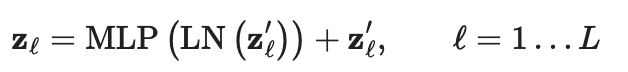

This equation states that for every layer from 1 through L there is also a MLP wrapping a LN.

The addition at the end is also showcasing a skip/residucal connection.

All of this is equivalent to the "MLP Block" layer.

This might look like:
```
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

#### 3.2.6 Equation 4 Overview

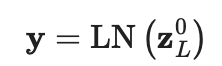

This applies to the last layer L, where the y output is said to be the 0 index token of z wrapped in a LN.

In our case, the 0 index of `x_output_MLP_block`

`y = Linear_Layer(LN_layer(x_output_MLP_block[0]))`



#### Exploring Table 1

The final piece of the ViT architecture that will be focused on for now is Table 1.

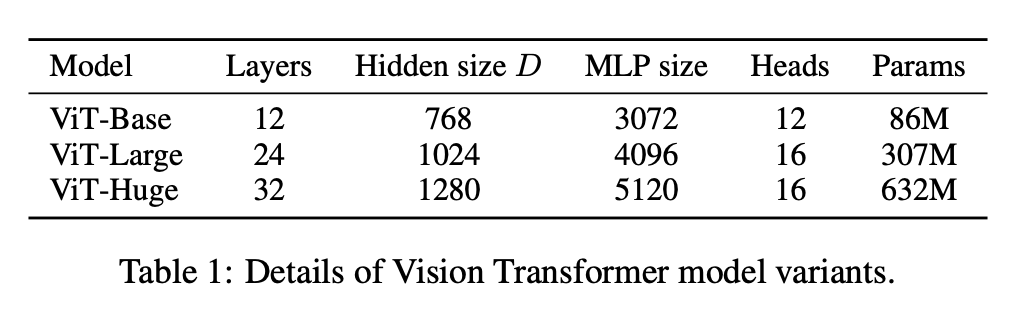

The above table showcases the hyperparameters of the ViT architectures, where we will begin with the ViT-Base.

Here is a breakdown of the hyperparameters:
* **Layers**: Number of Transformer Encoder blocks (each contains a MSA and MLP block)
* **Hidden Size D**:  The embedding dimension throughout the architecture. This is the size of the vector that our image gets turned into when it gets patched and embedded. A larger embedding captures more information while also becoming more computationally expensive.
* **MLP Size**: Number of hidden units in the MLP layers
* **Heads**: Number of heads in the Multi-Head Attention layers
* **Params**: Total number of parameters of the model. More parameters lead to better performance while also becoming more computationally expensive.



### 3.3 Replicating Papers Workflow

1. Read the whole paper end-to-end once (get an idea of the main concepts).
2. Go back through each section identifying links and connections that provide insight into how it might be turned into code.
3. Repeat step 2 until you have a good outline
4. Use [mathpix.com](https://mathpix.com/) to turns any sections of the paper into markdown/LaTex for the notebooks.
5. Replicate the simplest model version possible
6. Look for more examples when stuck

##4. Equation 1: Split data into patches and creating the class, position and patch embedding.

If you can represent your data in a good, learnable way (as embeddings are learnable representations), a learning algorithm is likely to perform well on them.

The first step we will do is work on the patch embeddings. Recall an embedding is a learnable representation of some form and is often a vector. It is important to note that embeddings are learnable because this means it can improve over time.

We will use the opening paragraph of section 3.1 of the ViT paper.

> An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2 D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

Regarding size, we are dealing with images shapes, where in a line from Table 3 of the paper it is stated that:



> Training reoslution is **224**.

Let's break down the text above.

* D is the size of the patch embeddings. Table 1 shows the various D values that can be used for various sized ViT models.
* The image starts as 2D with size $H \times W \times C$
 * $(H, W)$ is the resolution of the original image
 * C is the number of channels
* The image is converted to a sequence of flattened 2D patches with size $N \times (P^2 \cdot C)$.
 * $(P, P)$ is the resolution of each image patch (patch size)
 * $N = HW / P^2$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.  

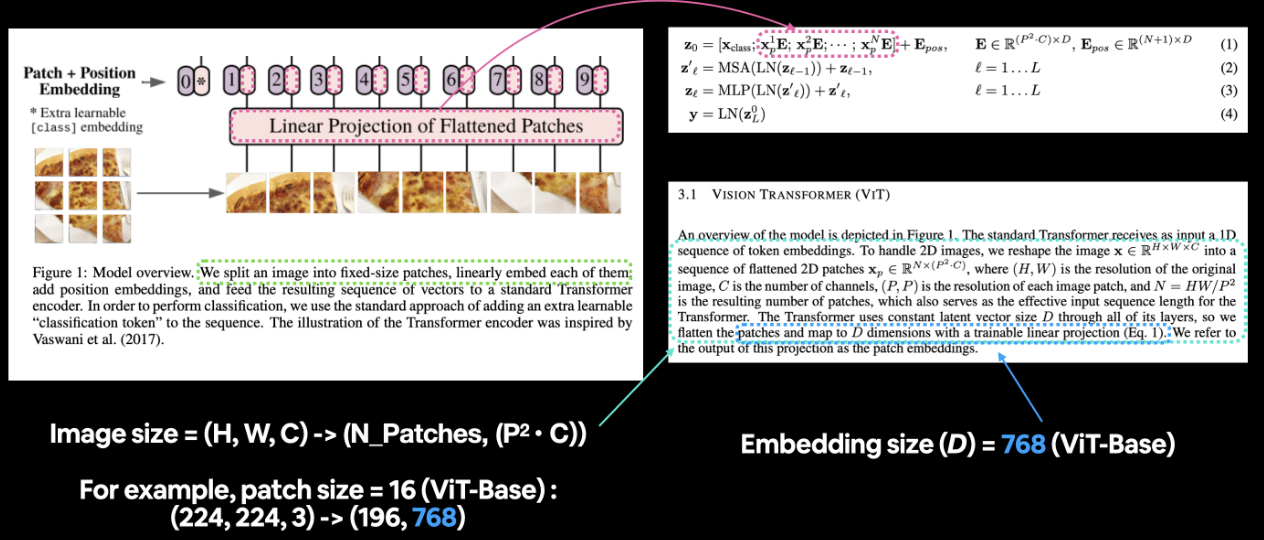

### 4.1 Calculating Patch Embedding Input and Output Shapes by Hand

Based on Table 5 from the paper, we can find the accuracy of the Vision Transformer on various datasets, with the Patch Size as a hyperparameter.

Within the ViT-Base uses, an accuracy of 98.13% is achieved with a Patch Size of 16. Hence, we will use this value for now.

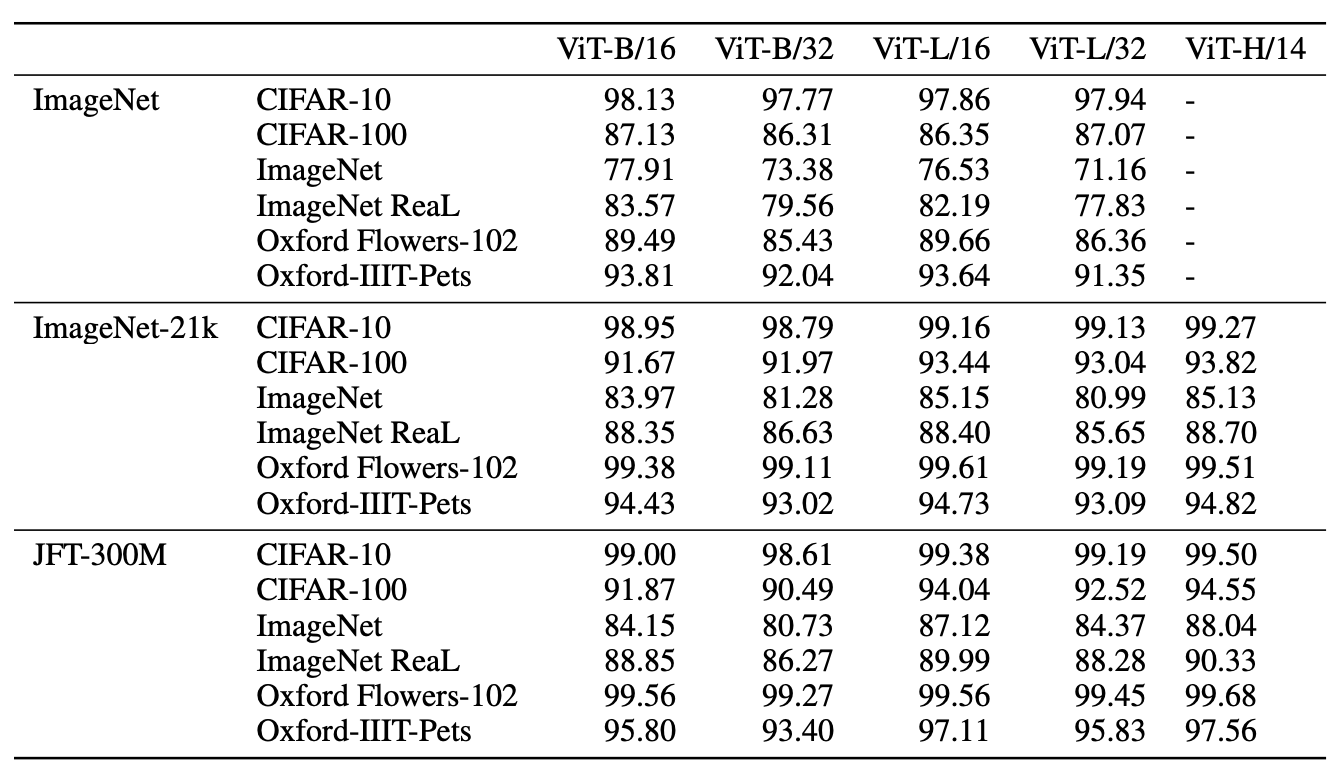

In [55]:
height = 224 # Training Resolution is 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height {height} (H), width {width} (W), and patch size {patch_size} (P): {number_of_patches}")

Number of patches (N) with image height 224 (H), width 224 (W), and patch size 16 (P): 196


To replicate the input and output shapes of the patch embedding layer, we must recall:

* Input: the image starts as 2D with size $H \times W \times C$
* Output: the image gets converted to a sequence of flattened 2D patches with size $N \times (P^2 \cdot C)$.

In [56]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 4.2 Turning a Single Image into Patches

Now we have the input and output shapes of the patch embedding layer. From here, we can start creating it.

Firstly, we will see what it means to turn an image into patches.

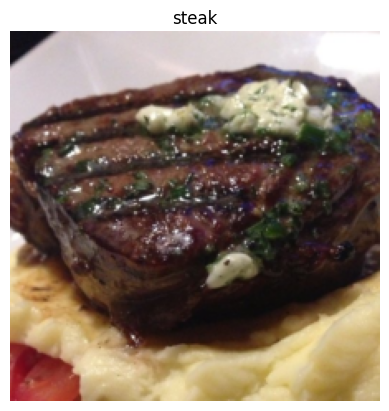

In [57]:
plt.imshow(image.permute(1, 2, 0)) # Changing CHW -> HWC for matplotlib
plt.title(class_names[label])
plt.axis(False);

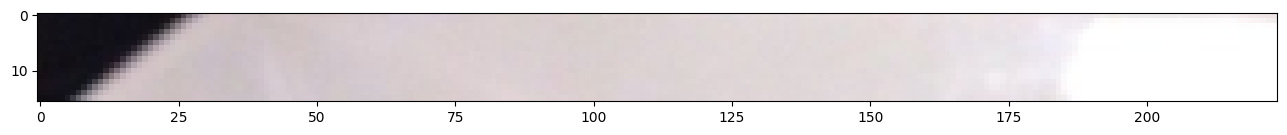

In [58]:
permuted_image = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(permuted_image[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


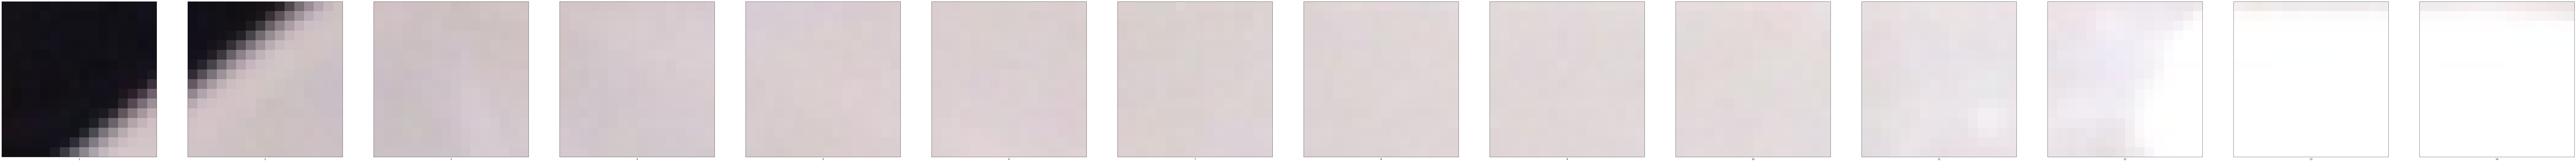

In [59]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(number_of_patches, number_of_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(permuted_image[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Seeing how the patches work for an individual image, we can now do it for the entire image.

To do so, we iterate through the indexes for height and width and plot each patch as it's own subplot.

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


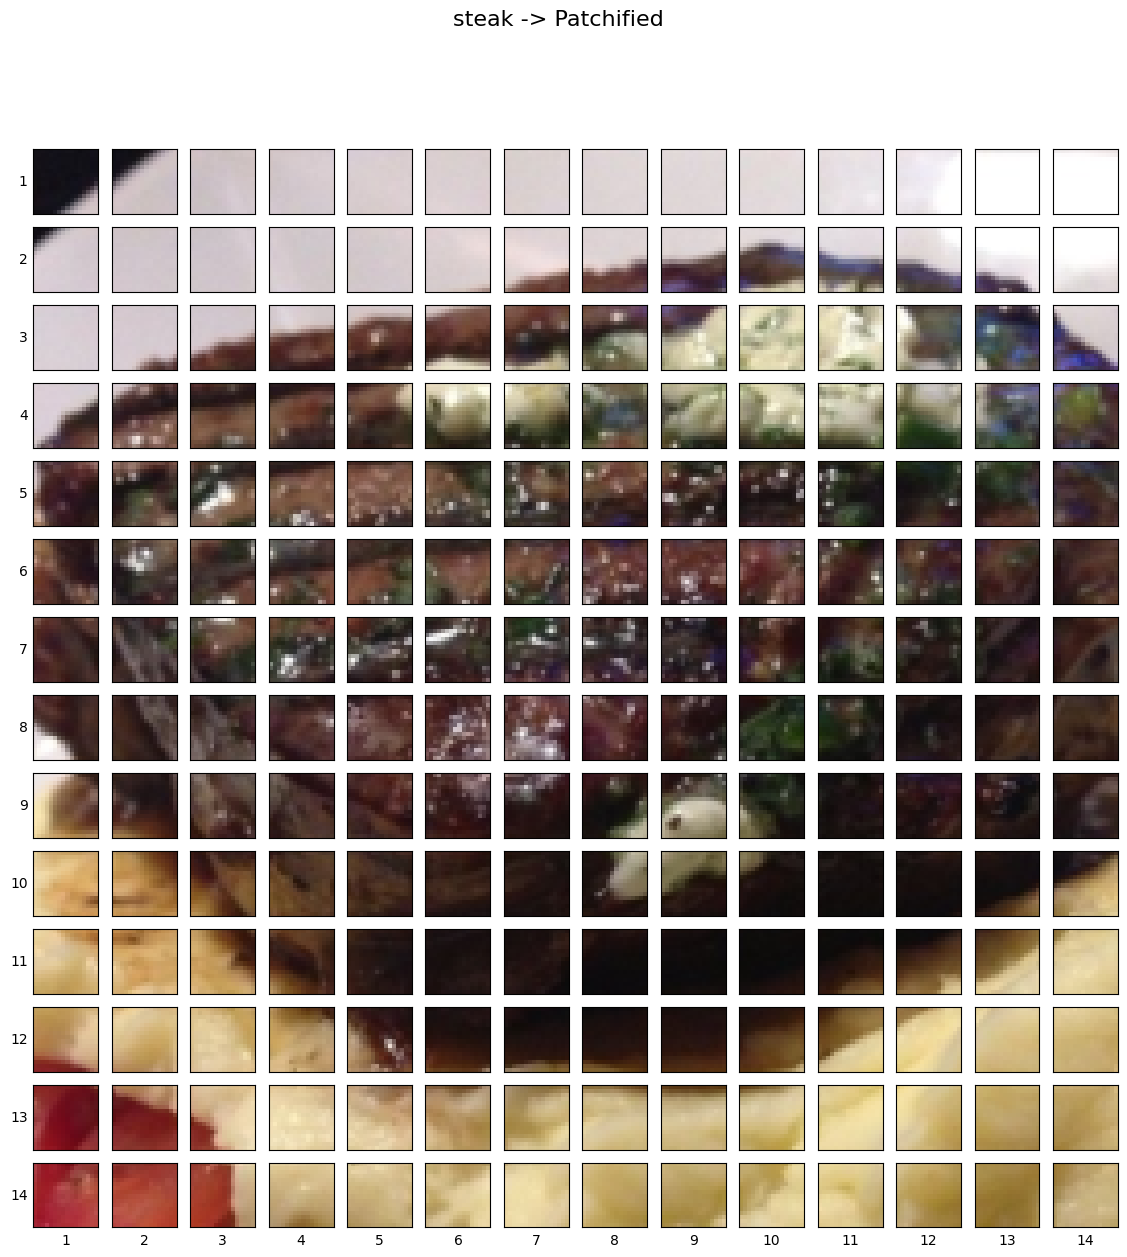

In [60]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Series of subplots
fig, axs = plt.subplots(nrows= img_size // patch_size, # can only handle ints
                        ncols= img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Looping throught the width and height of the image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

    # Plot permuted image (CHW -> HWC)
    axs[i, j].imshow(permuted_image[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]); # all color channels
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")

    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()


### 4.3 Creating image patches with `torch.nn.Conv2d()`

Given how an invidual image is patched, we can now work on replicating the patch embedding layers with PyTorch.

The way we looped through the $H \times W$ dimensions of the image is achievable through a CNN. This is in fact stated in section 3.1:



> Hybrid Architecture. As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection $\mathbf{E}$ (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.
The classification input embedding and position embeddings are added as described above.

The mentioned feature map refers to the weights/activations produced by a convolutional layer passing over a given image.

This behavior can be achieved by setting the `kernel_size` and `stride` parameters of `torch.nn.Conv2d()` to equal the `patch_size`. Through this we can get a layer that splits our image into patches and creates a learnable embedding of each patch.

For this, recall our ideal shapes for the patch embedding layer.

* Input: the image starts as 2D with size $H \times W \times C$
* Output: the image gets converted to a sequence of flattened 2D patches with size $N \times (P^2 \cdot C)$.

Or for an image size of 224 and patch size of 16.

* Input (2D image): (224, 224, 3) -> $(H,W,C)$
* Output (flatteened 2D patches): (196, 768) -> (number of patches, embedding dimension)

These can be recreated with:

* `torch.nn.Conv2d()` for turning our image into patches of CNN feature maps.
* `torch.nn.Flatten()` for flattening the spatial dimensions of the feature map.

Within the `torch.nn.Conv2d()` layer, we can recreate the patches where each convolutional kernel will be of size `(patch_size x patch_size)`.

Each step, or `stride` of the convolutional kernel will be `patch_size` pixels long.

We will set `in_channels=3` for the number of color channels while `out_channels=768`, the same as the D value in Table 1 for ViT-Base which is the embdding dimension (this means each imahe will be embedded into a learnable vector of size 768).



In [61]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

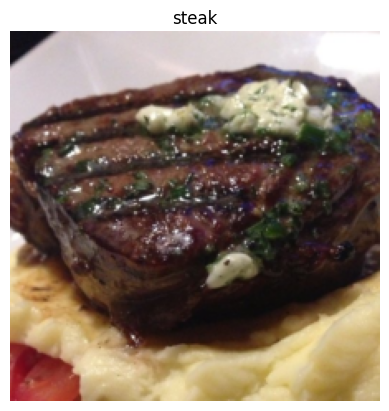

In [62]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [63]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # (HWC) -> (BHWC) where we add a single batch dimension
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


The output shape can be read as:



```
torch.size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```



Showing random convolutional feature maps from indexes: [502, 617, 26, 710, 228]


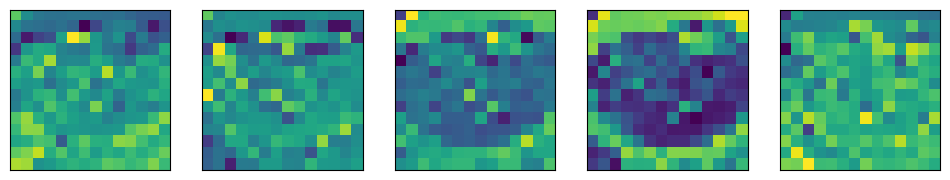

In [64]:
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Iterates over the different feature detectors of the same image
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # output tensor of the convolutional layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Despite working on the same image, the feature maps very different representations of the original image. The more representations we analyze, the easier it will be to pick up and major outlines and major features.

As the NN learns, these features are likely to change and update over time.

Therefore, these feature maps can be considered a learnable embedding of our image.

In [65]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0201,  0.3886,  0.3172,  0.3374,  0.3407,  0.3529,  0.3419,
            0.3520,  0.3415,  0.3542,  0.3629,  0.3845,  0.3930,  0.3951],
          [ 0.3794,  0.3299,  0.3362,  0.3319,  0.3375,  0.3758,  0.3056,
            0.2778,  0.1122,  0.0818,  0.2142,  0.1810,  0.2508,  0.3734],
          [ 0.3473,  0.3322,  0.2733,  0.1155,  0.0114,  0.2041,  0.1064,
            0.1200,  0.3522,  0.2297,  0.1802,  0.0835,  0.1184,  0.1701],
          [ 0.1355,  0.1749,  0.2068,  0.1170,  0.0645,  0.1046,  0.0333,
            0.0706,  0.2013,  0.1900,  0.1181,  0.0930,  0.1732,  0.1407],
          [ 0.0815,  0.0428,  0.0616,  0.3102,  0.1626,  0.0442,  0.0516,
            0.0353,  0.0803,  0.1274,  0.0922,  0.0601,  0.0438,  0.1364],
          [ 0.0535, -0.0097,  0.1169,  0.1183,  0.2019,  0.2406,  0.0636,
            0.1249,  0.2464,  0.1768,  0.1607,  0.1689,  0.1108,  0.1239],
          [ 0.0479,  0.1180,  0.1606,  0.1354,  0.1129,  0.0187, -0.0077,
            0.1380,  0.0440,  0.

The `grad_fn` output of the `single_feature_map` and the `requires-grad=True` attribute means PyTorch is tracking the gradients of ths feature map. Therefore, it is learning from it and it will be updated by gradient descent during training.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Our patch embeddings are in 2D format, while the desired outpout size is:

* (196, 768) -> (number of patches, embedding dimension) -> $N \times (P^2 \cdot C)$.

In [66]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


While the 768 part $(P^2 \cdot C)$. is correct, we still need the number of patches $(N)$.

When going over the paper, section 3.1 states the following:



> As a special case, the patches can have spatial size $1 \times 1$, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.

We can flatten throguh PyTorch's `torch.nn.Flatten()`. However, we have to be careful. The paper flattens the "spatial dimensions of the feature map," not the whole tensor.

Our equivalent to this would be the `feature_map_height` and `feature_map_width` dimensions of `image_out_of_conv`.



In [67]:
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height
                     end_dim=3) # flatten feature_map_width

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened feature map shape: torch.Size([1, 768, 196])


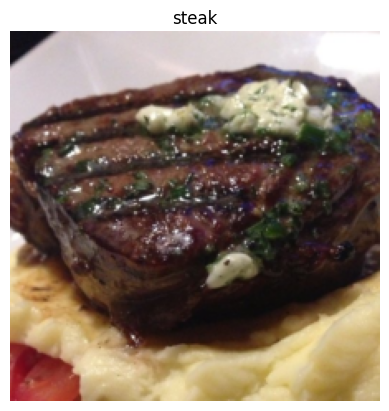

In [68]:
# View image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

# Flatten feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened feature map shape: {image_out_of_conv_flattened.shape}")

Our `image_out_of_conv_flattened` shape is very close to our desired output shape. We only have to permute the batch size and dimensions.

In [69]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


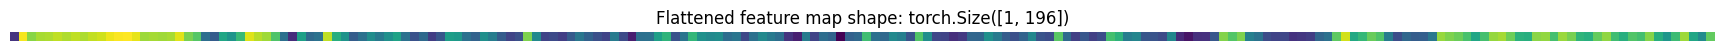

In [70]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

The flattened feature map doesn't look like much, which is due to its adaptation. The original transformer architecture was deisgned for text while ViT wanted to redesign it for images. Hence, the input of the ViT architecture is processed in a way where we format a 2D image as a 1D sequence of text.

In [71]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0201,  0.3886,  0.3172,  0.3374,  0.3407,  0.3529,  0.3419,  0.3520,
           0.3415,  0.3542,  0.3629,  0.3845,  0.3930,  0.3951,  0.3794,  0.3299,
           0.3362,  0.3319,  0.3375,  0.3758,  0.3056,  0.2778,  0.1122,  0.0818,
           0.2142,  0.1810,  0.2508,  0.3734,  0.3473,  0.3322,  0.2733,  0.1155,
           0.0114,  0.2041,  0.1064,  0.1200,  0.3522,  0.2297,  0.1802,  0.0835,
           0.1184,  0.1701,  0.1355,  0.1749,  0.2068,  0.1170,  0.0645,  0.1046,
           0.0333,  0.0706,  0.2013,  0.1900,  0.1181,  0.0930,  0.1732,  0.1407,
           0.0815,  0.0428,  0.0616,  0.3102,  0.1626,  0.0442,  0.0516,  0.0353,
           0.0803,  0.1274,  0.0922,  0.0601,  0.0438,  0.1364,  0.0535, -0.0097,
           0.1169,  0.1183,  0.2019,  0.2406,  0.0636,  0.1249,  0.2464,  0.1768,
           0.1607,  0.1689,  0.1108,  0.1239,  0.0479,  0.1180,  0.1606,  0.1354,
           0.1129,  0.0187, -0.0077,  0.1380,  0.0440,  0.1110,  0.0940, -0.0472,
           0.090

Hence, we have turned the 2D image into a 1D learnable embedding vector.

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

Now, we can put forward a layer with everything covered so far. This can be done by subclassing a `nn.Module` and creating a small PyTorch model. Specifically,

1. Create a class called `PatchEmbedding` whcih subclasses `nn.Module` (so it can be used as a PyTorch layer)
2. Initialize the class with the parameters `in_channels=3`, `patch_size=16` and `embedding_dim=768`
3. Create a later to turn an image into patches using `nn.Conv2d()`
4. Create a layer to flatten the patch feature maps into a single dimension
5. Define a `forward()` method to take an input and pass it through the layers created in 3 and 4
6. Make sure the output shape reflects the required output shape of the ViT architecture.

In [72]:
class PatchEmbedding(nn.Module):
  """
  Turns a 2D input image into a 1D sequence learnable embedding vector.

  Args:
    in_channels(int): Number of color channels for the input images. Defaults to 3
    patch_size (int): Size of patches to convert input image into. Defaults to 16.
    embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
  """

  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
      super().__init__()

      # Layer that turns images into patches
      self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)

      # Layer that flattens the patch feature maps into a single a dimension
      self.flatten = nn.Flatten(start_dim=2,
                                end_dim=3)

  def forward (self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch_size: {patch_size}"

    # Forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1) # make sure embedding has final dimension [batch_size, N, P^2 x C]


In [73]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


The output shapes matches the ideal input and output shapes from the patch embedding layer where:
* $(H, W)$ is the resolution of the original image.
* C is the number of channels.
* $(P, P)$ is the resolution of each image patch (patch size)
* $N = HW / P^2$ is the resulting number of patches, which also serves as the effective input sequence length of the Transformer.

Hence, we have now replicated the Patch Embedding for Equation 1, but not the class token/position embedding.

In [74]:
random_input_image=(1, 3, 224, 224)

summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 4.6 Creating Class Token Embedding

The second paragraph of section 3.1 states the following:

> Similar to BERT's `[ class ]` token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4).

It is important to recall that BERT is one of the original ML research papers to use the Transformer architecture to achieve outstanding results on NLP tasks. This is where the idea of having a `[ class ]` token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.

Hence, the next step is to "prepend a learnable embedding to the sequence of embedded patches."





In [75]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.3784,  0.1080, -0.1363,  ...,  0.2367, -0.0610,  0.0630],
         [-0.8804,  0.3170, -0.2992,  ...,  0.4524, -0.0339,  0.2031],
         [-0.8256,  0.2180, -0.2425,  ...,  0.6179, -0.3661,  0.2729],
         ...,
         [-0.5628,  0.0680, -0.1037,  ...,  0.3958, -0.3605,  0.2624],
         [-0.5419,  0.0762, -0.0957,  ...,  0.3269, -0.2990,  0.2079],
         [-0.7412,  0.1955, -0.2196,  ...,  0.5077, -0.2739,  0.2302]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


We need to create a learnable embedding in the shape of the `embedding_dimension` (D) and then add it to the `number_of_patches` dimension.


```
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
```

To create a learnable embedding for the class token, we will get the batch size and embedding dimension shape, and then create a `torch.ones()` tensor in the shape `[batch_size, 1, embedding_dimension]`.

Then, the tensor will be made learnable by passing it to `nn.Parameter()` with `requires_grad=True`.


In [76]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

print(class_token[:, :, :10])
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


For demonstration purposes we use `torch.ones()` now, but normally one would use `torch.randn()` to harness the power of controlled randomness.

The `number_of_tokens` dimension of `class_token` is `1` since we only want to prepend one class token value to the start of the patch embedding sequence. Now that we have the class token embedding, we can prepend it to our sequence of image patches, `patch_embedded_image`.

In [77]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3784,  0.1080, -0.1363,  ...,  0.2367, -0.0610,  0.0630],
         [-0.8804,  0.3170, -0.2992,  ...,  0.4524, -0.0339,  0.2031],
         ...,
         [-0.5628,  0.0680, -0.1037,  ...,  0.3958, -0.3605,  0.2624],
         [-0.5419,  0.0762, -0.0957,  ...,  0.3269, -0.2990,  0.2079],
         [-0.7412,  0.1955, -0.2196,  ...,  0.5077, -0.2739,  0.2302]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


The learnable class token has been prepended along `dim=1` to the number of patches, and will be optimized throughout training due to `requires_grad=True`.

### 4.7 Creating Position Embedding

The next step is to create the position embedding which is the $\mathbf{E}_{pos}$ variable from equation 1 where $\mathbf{E}$ stands for embedding.

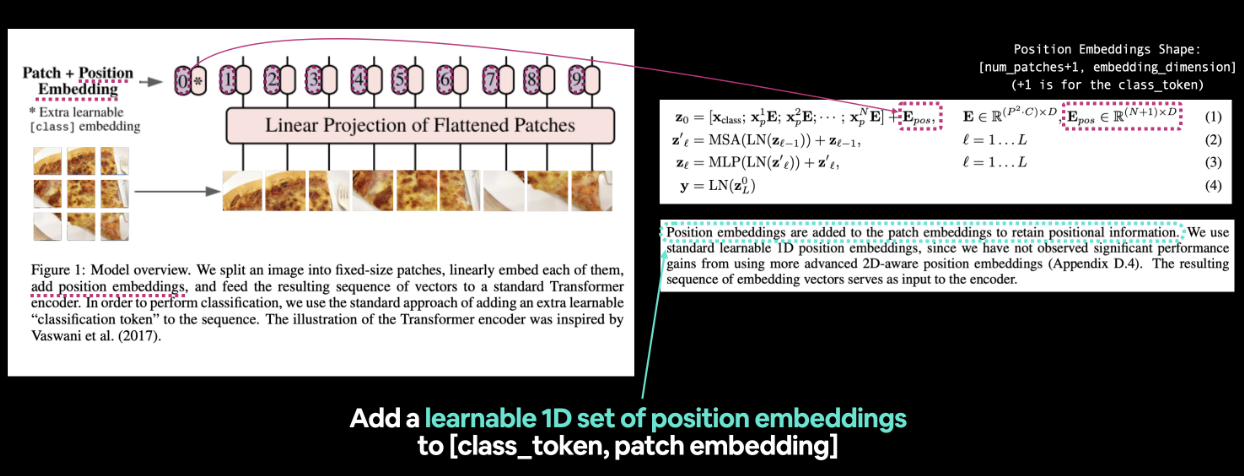

Section 3.1 of the paper provides more insight into these position embeddings:



> Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

The architecture of Transformers make them more of a set operation rather than a sequential operation. Therefore, this makes them content-based instead of order-based, meaning that within NLP, if we had two sentences with the same words but different word order, their output would be the same. Therefore, in order to provide the positioning of the elements of our data meaning, we assign them a positional embedding to retain their position information.



In [78]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3784,  0.1080, -0.1363,  ...,  0.2367, -0.0610,  0.0630],
          [-0.8804,  0.3170, -0.2992,  ...,  0.4524, -0.0339,  0.2031],
          ...,
          [-0.5628,  0.0680, -0.1037,  ...,  0.3958, -0.3605,  0.2624],
          [-0.5419,  0.0762, -0.0957,  ...,  0.3269, -0.2990,  0.2079],
          [-0.7412,  0.1955, -0.2196,  ...,  0.5077, -0.2739,  0.2302]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Equation 1 states that the position embeddings $\left(\mathbf{E}_{\mathrm{pos}}\right)$ should have the shape $(N+1) \times D$ :
$$
\mathbf{E}_{\mathrm{pos}} \in \mathbb{R}^{(N+1) \times D}
$$

Where:

- $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
- $D$ is the size of the patch embeddings, different values for $D$ can be found in Table 1 (embedding dimension).

Luckily we have both values, so we can now make the learnable 1D embedding with `torch.ones()` to create $\mathbf{E}_{\mathrm{pos}}$.

In [79]:
number_of_patches = int((height * width) / patch_size ** 2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Now we can add the position embeddings with a prepend class token.

In [80]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6216, 1.1080, 0.8637,  ..., 1.2367, 0.9390, 1.0630],
         [0.1196, 1.3170, 0.7008,  ..., 1.4524, 0.9661, 1.2031],
         ...,
         [0.4372, 1.0680, 0.8963,  ..., 1.3958, 0.6395, 1.2624],
         [0.4581, 1.0762, 0.9043,  ..., 1.3269, 0.7010, 1.2079],
         [0.2588, 1.1955, 0.7804,  ..., 1.5077, 0.7261, 1.2302]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768])


### 4.8 Putting it all together, from image to embedding

$\mathbf{z}_0=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\mathrm{pos}}, \quad \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\mathrm{pos}} \in \mathbb{R}^{(N+1) \times D}$

Now, we can put everything together in a single code cell from input image (x) to output embedding ($z_0$).

We can do this by:

1. Setting the patch size (we will use 16 as it is widely used throughout the paper and for ViT-Base)
2. Getting a single image, printing its shape and storing its height and width
3. Adding a batch dimension to the single image so it is compatible with our `PatchEmbedding` layer
4. Creating a `PatchEmbedding` layer with a `patch_size=16` and `embedding_dim=768`
5. Passing the single image through the `PatchEmbedding` layer to create a sequence of patch embeddings.
6. Creating a class token embedding
7. Prepending the class token embedding to the patch embeddings
8. Creating a position embedding
9. Adding the position embedding to the class token and patch embeddings

In [81]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multi-Head Attention (MSA)

Now that our input data is patchified and embedded, we can move on. We will start by breaking down the Transformer Encoder into equations 2 and 3.

Recall equation 2:

$\mathbf{z}_{\ell}^{\prime}=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, \quad \ell=1 \ldots L$

This indicates a LN layer with a residual connection wrapped in a MSA layer. This is known as the residual block.

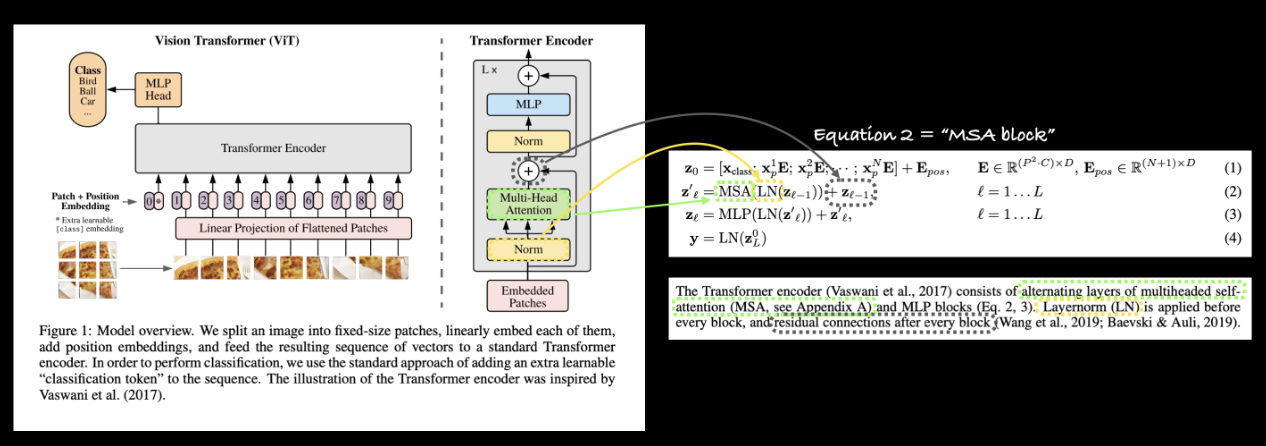

Given the above mapping from the ViT layers to the equations, we can reuse many layers that are already implemented in PyTorch, such as:

* **Multi-Head Self Attention (MSA)** - `torch.nn.MultiheadAttention()`
* **Norm (LN or LayerNorm)** - `torch.nn.LayerNorm()`
* **Residual connection** - add the input to output

### 5.1 LayerNorm (LN) layer

Layer Normalization (`torch.nn.LayerNorm()`) normalizes an input over the last dimension.

PyTorch's `torch.nn.LayerNorm()`'s main parameter is `normalized_shape` which we can set to be equal to the dimension size we would like to normalize over (in our case it will be $D$ or 768 for ViT-Base).

Layer Normalization helps improve training time and model generalization by getting data samples into a similar distribution.

### 5.2 Multi-Head Self Attention (MSA) layer

The power of self-attention and mult-head attention were revealed in the original Transformer architecture introduced in the [Attention is all you need](https://arxiv.org/abs/1706.03762)research paper.

Originally designed for text-inputs, the original self-attention mechanism takes a sequence of words and calculates which word should pay more "attention" to another word.

For images, the premise remains.

Self-attention and multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image. Said layer does this on its own give data (we do not tell it what patterns to learn).

If the learned representations the layers form using MSA are good, it will lead to a good model performance.

Here are some resources about the Transformer architecture:

[Illustrated Transformer Post](https://jalammar.github.io/illustrated-transformer/)
[Illustrated Attention Post](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)



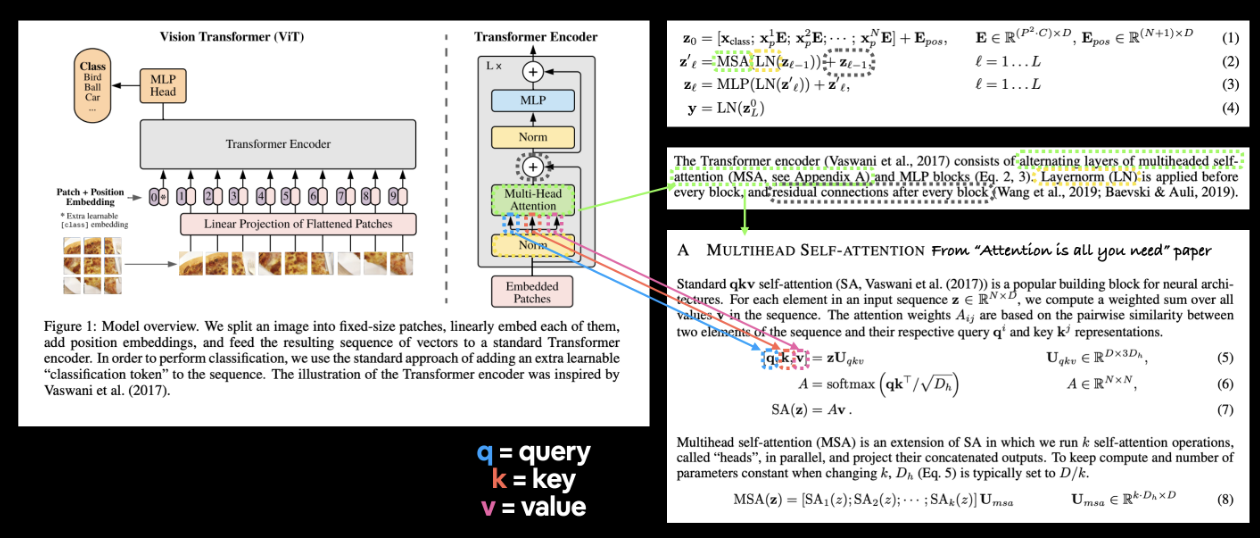

Seen above, there is a triple embedding input to the MSA layer.

This is known as **query, key, value** input or **qkv** for short which is fundamental to the self-attention mechanism.

In our case, the triple embedding input will be three version of teh output of the Norm layer, one for query, key, and value.

We can implement the MSA layer in PyTorch with `torch.nn.MultiheadAttention()` with the parameters:

* `embed_dim` - the embedding dimension (hidden size $D$ from Table 1)
* `num_heads` - how many attention heads to use
* `dropout` - whether or not to apply dropout to the attention layer (according to Appendex B.1, dropout isn't used in the qkv-projections)
* `batch_first` - does our batch dimension come first? (yes it does)

### 5.3 Replicating Equation 2 with PyTorch layers

This is how we can put everything together:

1. Create a class called `MultiheadSelfAttentionBlock` that inherits from `torch.nn.Module`
2. Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameters the same as our embedding dimension ($D$ from Table 1)
4. Create a multi-head attention (MSA) layer with the appropriate `embed_dim`, `num_heads`, `dropout` and `batch_first` parameters.
5. Create a `forward()` method for our class passing the inputs through the LN layer and MSA layer

In [82]:
class MultiheadSelfAttentionBlock (nn.Module):

  def __init__(self,
               embedding_dim:int=768, # hidden size D from Table 1
               num_heads:int=12, # heads from Table 1 for ViT-Base
               attn_dropout:float=0): # paper does not use dropout for MSA-blocks
      super().__init__()

      self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

      self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  dropout=attn_dropout,
                                                  batch_first=True) # batch dimension comes first
  def forward (self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                         key=x, # key embeddings
                                         value=x, # value embeddings
                                         need_weights=False) # do we need the weights or just the layer outputs
    return attn_output

Unlilke Figure 1, our `MultiheadSelfAttentionBlock` does not include a skip or residual connection ($+z_{l-1}$ in equation 2). This will be included when we create the entire Transformer Encoder.

In [83]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP)

Now we will replicate equation 3:

$\mathbf{z}_{\ell}=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \quad \ell=1 \ldots L$

For this equation we use the multilayer perceptron alongside the layer normalization, followed by a skip/residual connection.

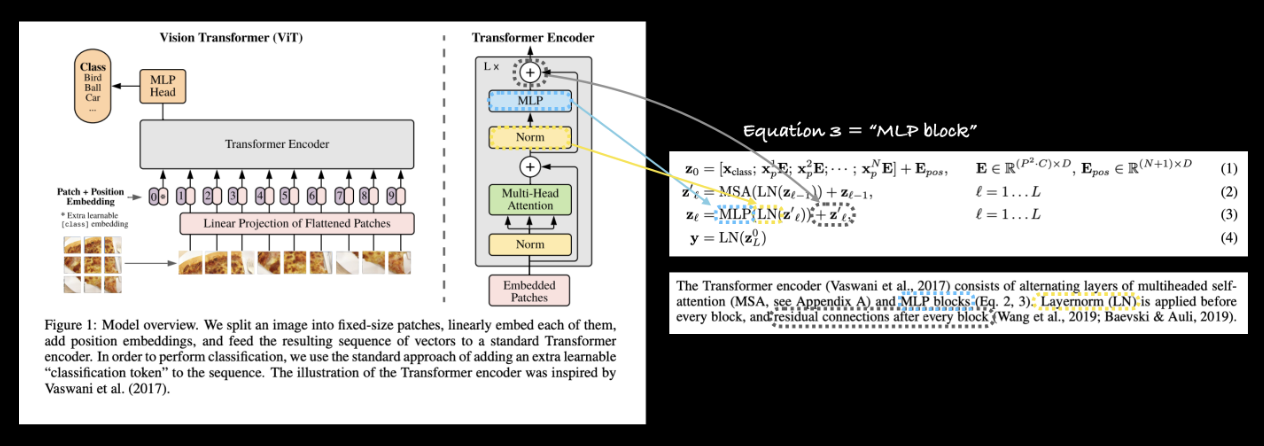

### 6.1 The MLP Layer(s)

MLPs generally follow the below pattern:

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

Within the ViT paper, the MLP structure is defined in section 3.1:



> The MLP contains two layers with a GELU non-linearity

The linear layers refer to `torch.nn.Linear()` while the GELU non-linearity refers to `torch.nn.GELU()`.

Appendix B.1 has some detail over our layers as well:


> Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.

Hence, every linear layer in the MLP block has a dropout layer (`torch.nn.Dropout()`). The value of the dropout layer can be found in Table 3 of the ViT paper, where it is `dropout=0.1`.


Hence, the structure of the MLP block is:
`layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout`




### 6.2 Replicating Equation 3 with PyTorch layers

We can make a class for equation 3. To do so, we will:

1. Create a class called `MLPBlock` that inherits from `torch.nn.Module`
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as our embedding dimension ($D$ from Table 1)
4. Create a sequential series of MLP layers using `torch.nn.Linear()`, `torch.nn.Dropout()` and `torch.nn.GELU()` with appropriate hyperparameter values from Table 1 and Table 3
5. Create a `forward()` method for our class passing the inputs through the LN layer and MLP layer(s)

In [84]:
class MLPBlock(nn.Module):
  """
  Creates a layer normalized multilayer perceptron block (MLP block)
  """

  def __init__ (self,
                embedding_dim:int=768, # Hidden Size D from Table 1
                mlp_size:int=3072, # MLP size from Table 1
                dropout:float=0.1): # Dropout from Table 3

      super().__init__()

      self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

      self.mlp = nn.Sequential(
          nn.Linear(in_features=embedding_dim, out_features=mlp_size),
          nn.GELU(),
          nn.Dropout(p=dropout),
          nn.Linear(in_features=mlp_size, out_features=embedding_dim), # make sure its input size matches the output size of the above layer
          nn.Dropout(p=dropout)
      )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [85]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


Notice how the shape of the input remains unchanged.

However, the shape does change with it passes through the `nn.Linear()` lalyers within the MLP block.

## 7. Create the Transformer Encoder

By stacking the `MultiheadSelfAttentionBlock` with the `MLPBlock`, we can create the Transformer Encoder architecture.

Within Deep Learning, an encoder generally refers to a stack of layers that "encodes" an input by turning it into some form of numerical representation.

Given our paper, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per section 3.1 of the ViT paper:



> The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

Given the blocks, we are missing residual connections. Residual/skip connections were first introduced in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385v1) and are achieved by adding a layer(s) input to its subsequent output, where said output might be one or more layers later.

Within our architecture, this means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block. The same happens with the MLP block before it goes onto the next Transformer Encoder block.

In pseudocode, the equivalent is:
`x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...`

Residual connections prevent weight values and gradient updates from getting too small, allowing deeper networks and in turn allow deeper representations to be learned.



### 7.1 Creating a Transformer Encoder by combining our custom made layers

To make our ViT Transformer Encoder with PyTorch, we will:

1. Create a class called `TransformerEncoderBlock` that inherits from `torch.nn.Module`
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model
3. Instantiate a MSA block for equation 2 using the `MultiheadSelfAttentionBlock` with the appropriate parameters
4. Instantiate a MLP block for equation 3 using our `MLPBlock` from with the appropriate parameters
5. Create a `forward()` method for our `TransformerEncoderBlock` class
6. Create a residual connection for the MSA block
7. Create a residual connection for the MLP block

In [86]:
class TransformerEncoderBlock(nn.Module):
  """
  Creates a Transformer Encoder block
  """

  def __init__(self,
               embedding_dim:int=768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:float=0.1,
               attn_dropout:float=0):

    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [87]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

So far the Transformer Encoder has been built with our own layers. However, PyTorch has in-built Transformer layers as part of `torch.nn`.

In [88]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True) # normalize first or after MSA/MLP layers

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [89]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

There are slight discrepancies between both summaries due to how `torch.nn.TransformerEncoderLayer()` constructs its layer.

However, the layers it uses, number of parameters, and input and output shapes are the same.

Reproducing equations yields good practice, and more greater control over the entire architecture. However, there are benefits from using the PyTorch pre-built layers:

* Less prone to errors: Generally, if a layer makes it into the PyTorch standard library, it has been tested and tried to work
* Potentially better performance: PyTorch's `torch.nn.TransformerEncoderLayer()` can see a speedup in comparison to other workloads

Since the ViT architecture uses several Transformer Layers stacked on top of each other for the full architecture, this can be done with `torch.nn.TransformerEncoder(encoder_layer, num_layers)` where:
* `encoder_layer`: The target Transformer Encoder layer created with `torch.nn.TransformerEncoderLayer()`
* `num_layers`: The number of Transformer Encoder layers to stack together

## 8. Putting it all together to create ViT

Before placing all parts together, we have to create equation 4, which is:

$\mathbf{y}=\mathrm{LN}\left(\mathbf{z}_L^0\right)$

For this equation, we need a `torch.nn.LayerNorm()` layer and a `torch.nn.Linear()` layer to convert the 0th index ($z_0^L$) of the Transformer Encoder logit outputs to the target number of classes we have.

Furthermore, to create the full architecture, we need to stack of a number of `TransformerEncoderBlock`s on top of each other. We can do this by passing a list of them to `torch.nn.Sequential()` (this will make a sequential range of `TransformerEncoderBlock`s)

To carry out the ViT implementation, we have to do the following:

1. Create a class called ViT that inherits from `torch.nn.Module`
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model
3. Make sure the image size is divisible by the patch size
4. Calculate the number of patches using the formula $N = HW / P^2$, where $H$ is the image height, $W$ the image width, and $P$ is the patch size
5. Create a learnable class embedding token (equation 1)
6. Create a learnable position embedding vector (equation 1)
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper
8. Create the patch embedding layer using the `PatchEmbedding` class
9. Create a series of Transformer Encoder blocks by passing a list of `TransformerEncoderBlock`s created in section 7.1 to `torch.nn.Sequential()`
10. Create the MLP head by passing a `torch.nn.Layernorm()` (LN) layer and a `torch.nn.Linear(out_features=num_classes)` layer, where `num_classes` is the target number of classes, to `torch.nn.Sequential()`
11. Create a `forward()` method that accepts an input
12. Get the batch size of the input (first dimension of the shape)
13. Create the patching embedding
14. Create the class token embedding and expand it across the number of batches from step 11 using `torch.Tensor.expand()` from equation 1
15. Concatenate the class token embedding to the first dimension of the patch embedding using `torch.cat()`
16. Add the position embedding to the patch and class token embedding
17. Pass the patch and position embedding through the dropout layer
18. Pass the patch and position embedding through the stack of Transformer Encoder layers
19. Pass index 0 of the output of the stack of Transformer Encoder layers through the classifier head

In [96]:
class ViT(nn.Module):

  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1,
               num_classes:int=1000):

    super().__init__()
    assert img_size % patch_size == 0, f"Image size must be divisible by patch_size. Image size: {img_size}, Patch size: {patch_size}"

    self.num_patches = (img_size*img_size) // patch_size**2
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                           requires_grad=True)
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # We stack the Transformer Encoer Blocks by using all of the layers (through *)
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward (self, x):

    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1, -1) # with -1 we are inferring the dimension, meaning we retain the size of this dimension as it was in the original tensor
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])
    return x


In the above class module we infer the dimensions of the tensors. Below is an example that showcases said functionality.

In [97]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [102]:
set_seeds()
random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### 8.1 Visual summary of ViT model

In [103]:
from torchinfo import summary

summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

The total number of parameters is 85,800,963, which is the biggest model used yet.

PyTorch's pre-trained ViT-Base with patch size 16 at `torch.vision.models.vit_b_16()` has 86,567,656 parameters. This number is since it was trained with ImageNet's 1000 classes. Therefore, if we set up the `ViT()` model with `len(class_names) = 1000` it would cause the number of parameters to match.

## 9. Setting up training code for the ViT model

To train the model we can import the `train()` function from `going_modular.going_modular.engine`.

Prior, we need to set up a loss function and an optimizer.

### 9.1 Creating an Optimizer

Section 4.1 of the paper tackles the optimizer on the Training and Fine-tuning states:

> Training \& Fine-tuning. We train all models, including ResNets, using Adam (Kingma \& $\mathrm{Ba}, 2015$ ) with $\beta_1=0.9, \beta_2=0.999$, a batch size of 4096 and apply a high weight decay of 0.1 , which we found to be useful for transfer of all models (Appendix D. 1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

Based on the paper, they use `torch.optim.Adam()` instead of `torch.optim.SGD()`. Furthermore they set `torch.optim.Adam(betas=(0.9, 0.999))` for the `betas` parameter.

The paper also uses weight decay which leads to slowly reducing the values of the weights during optimization to prevent overfitting. This can be set with `torch.optim.Adam(weight_decay=0.3)` based on the ViT value.

According to the setting of ViT trained on ImageNet-1k from Table 3, the learning rate of the optimizer should be set to 0.003 as stated in Table 3.

Due to hardware limitations, the batch size that will be used will be lower than 4096.



### 9.2 Creating a loss function

The ViT paper states nothing regarding "loss" or "loss function". Therefore, since we are tackling multi-class classification, we can use `torch.nn.CrossEntropyLoss()`

### 9.3 Training out ViT Model



In [ ]:
from going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()
set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

The model works, however, the results are not too optimistic.

### 9.4 Missing elements from the training setup

There are a few reasons why our model is underperforming, with one being scale.

The original ViT paper uses a far larger amount of data and a longer training schedule. Within Deep Learning, more data is generally always a good thing.

| Hyperparameter Value      | ViT Paper                                          | Our Implementation |
|---------------------------|----------------------------------------------------|--------------------|
| Number of training images | 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) | 225                |
| Epochs                    | 7 (for largest dataset), 90, 300 (for ImageNet)    | 10                 |
| Batch size                | 4096                                               | 32                 |
| Learning rate warmup      | 10k steps (Table 3)                                | None               |
| Learning rate decay       | Linear/Cosine (Table 3)                            | None               |
| Gradient clippin          | Global norm 1 (Table 3)                            | None               |

Despite sharing the architecture, the ViT paper used far mroe data and a more elaborate training scheme. The learning rate warmup, learning rate decay, and gradient clipping in the paper are designed to prevent overfitting due to its high number of parameters.

### 9.5 Loss curves of the ViT model

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

Although the loss seems to be headed in the right direction, the accuracy curves are not really promising. The model is apparently underfitting. We can compare this performance with a pretrained ViT model.

## 10. Using a pretrained ViT from `torchvision.models` on the same dataset

Due to the non-optimal results seen so far, we can use transfer learning to identify the the key differences.

### 10.1 Getting a pretrained ViT model and creating a feature extractor

In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

In [ ]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

The total number of parameters, 85,800,963, is the same as our custom made ViT model above.

However, the number of trainable parameters for `pretrained_vit` us much lower than the custom `vit` with only 2,307 compared to 85,800,963.

This means the pretrained model should train a lot faster. Hence, we could use a larger batch size since less parameter updates will take up memory.

### 10.2 Preparing data for the pretrained ViT model

In [ ]:
from helper_functions import download_data

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

### 10.3 Train feature extractor ViT model

In [ ]:
from going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

Based on the above metrics the ViT feature extractor performed a lot better than the custom ViT model trained from scratch given the same amount of time.

### 10.4 Plot feature extractor ViT model loss curves

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

In comparison to the previous loss curves, the loss curves above are really good looking loss curves. Using the same model architecture, we got outstanding results by using hte power of pretrained weights from ImageNet.

### 10.5 Save feature extractor ViT model and check file size

In [ ]:
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

For deployment reasons, it would be insightful to know the size of the model.

In [ ]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")